# Import Libraries

In [14]:
import glob
import pandas as pd
import numpy as np
import re

# Creating Dataset from txt files

## Extract data from all of the txt files

In [15]:
file_list = glob.glob("Q3/*txt")
dataset = []
for file in file_list:
  texts = open(file)
  lines = [line.strip() for line in texts]
  for line in lines:
    if line[:3]!='###':
      dataset.append(line)

In [16]:
df_value=[]
for data in dataset:
  data = data.replace('\t',' ')
  data = re.split(r"(AIMX|OWNX|CONT|BASE|MISC)",data,maxsplit=1)
  for dat in data:
    if dat!='':
      df_value.append(dat)

In [17]:
df_value = np.expand_dims(df_value,axis=1).reshape(-1,2)

In [18]:
df = pd.DataFrame(df_value,columns=['label','data'])

In [19]:
df

,label,data
0,MISC,The Minimum Description Length principle for ...
1,MISC,"If the underlying model class is discrete, th..."
2,MISC,"For MDL, in general one can only have loss bo..."
3,AIMX,We show that this is even the case if the mod...
4,OWNX,We derive a new upper bound on the prediction...
...,...,...
3112,MISC,This paved the way for the development of pre...
3113,MISC,"To our knowledge, the first of these methods ..."
3114,BASE,"Although our method, detailed in the followin..."
3115,OWNX,By the latter we consider a seemingly trivial...


# Training

In [64]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt


In [65]:
encoder = LabelBinarizer()
encoder.fit(df['label'])
y = encoder.transform(df['label'])

In [66]:
[np.argmax(item) for item in encoder.transform(['AIMX','OWNX','CONT','BASE','MISC'])]

[0, 4, 2, 1, 3]

In [67]:
MAX_FEATURES = 200000

vectorizer = TextVectorization(max_tokens=MAX_FEATURES,
                               output_sequence_length=180,
                               output_mode='int')

vectorizer.adapt(df['data'].values)
vectorized_text = vectorizer(df['data'].values)

In [68]:
vectorized_text = vectorized_text.numpy()

In [69]:
np.shape(vectorized_text)

(3117, 180)

In [70]:
np.shape(y)

(3117, 5)

In [71]:
X_train_val,X_test,y_train_val,y_test = train_test_split(vectorized_text,y,test_size=0.2,random_state=1)
X_train,X_val,y_train,y_val = train_test_split(X_train_val,y_train_val,test_size=0.2,random_state=1)

In [72]:
print(len(X_train))
print(len(X_test))
print(len(X_val))

1994
624
499


In [73]:
model = Sequential()
model.add(Embedding(MAX_FEATURES+1, 32))
model.add(Bidirectional(LSTM(32, activation='tanh')))
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(5, activation='softmax')) 
model.compile(loss='categorical_crossentropy', optimizer='Adam',metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          6400032   
                                                                 
 bidirectional (Bidirectiona  (None, 64)               16640     
 l)                                                              
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 5)                 645       
                                                      

In [74]:
history = model.fit(X_train,y_train, epochs=10, validation_data=(X_val,y_val))

Epoch 1/10
63/63 [==============================] - 71s 162ms/step - loss: 1.1548 - accuracy: 0.5797 - val_loss: 0.9865 - val_accuracy: 0.6032
Epoch 2/10
63/63 [==============================] - 5s 75ms/step - loss: 0.7959 - accuracy: 0.6886 - val_loss: 0.5940 - val_accuracy: 0.8016
Epoch 3/10
63/63 [==============================] - 4s 65ms/step - loss: 0.4527 - accuracy: 0.8360 - val_loss: 0.5424 - val_accuracy: 0.8457
Epoch 4/10
63/63 [==============================] - 4s 67ms/step - loss: 0.3490 - accuracy: 0.8746 - val_loss: 0.5291 - val_accuracy: 0.8297
Epoch 5/10
63/63 [==============================] - 5s 73ms/step - loss: 0.2727 - accuracy: 0.8862 - val_loss: 0.5830 - val_accuracy: 0.8297
Epoch 6/10
63/63 [==============================] - 4s 63ms/step - loss: 0.2451 - accuracy: 0.8947 - val_loss: 0.6144 - val_accuracy: 0.8437
Epoch 7/10
63/63 [==============================] - 4s 71ms/step - loss: 0.2322 - accuracy: 0.8997 - val_loss: 0.6199 - val_accuracy: 0.8417
Epoch 8/10


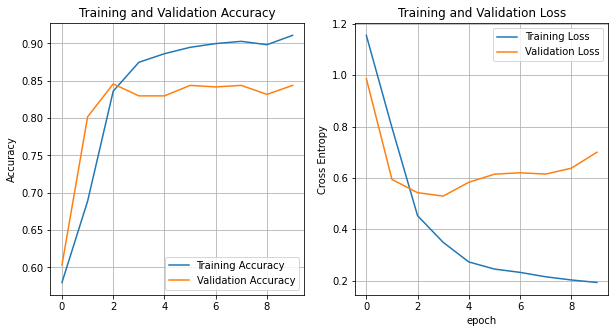

In [75]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
plt.figure(figsize=(10, 5))
plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['font.size'] = 10
plt.rcParams['axes.grid'] = True
plt.rcParams['figure.facecolor'] = 'white'
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Evaluate Model

In [76]:
y_pred = model.predict(X_test)

20/20 [==============================] - 3s 23ms/step


In [77]:
label_pred = np.array([np.argmax(item) for item in y_pred])
label_test = np.array([np.argmax(item) for item in y_test])
print(len(label_pred), len(label_test))

624 624


In [78]:
CategoricalAccuracy = sum(label_pred == label_test)/len(label_test)
print("The Categorical Accuracy is :", np.round(CategoricalAccuracy,4)*100,'%')

The Categorical Accuracy is : 84.46000000000001 %


# Save Model and Vectorizer

In [79]:
import pickle

In [80]:
model.save("Q3.h5")

In [81]:
pickle.dump({'config': vectorizer.get_config(),
             'weights': vectorizer.get_weights()}
            , open("vectorizer.pkl", "wb"))

# Inference

In [82]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import TextVectorization
import pickle

In [83]:
model = load_model("Q3.h5")

from_disk = pickle.load(open("vectorizer.pkl", "rb"))
vectorizer = TextVectorization.from_config(from_disk['config'])
vectorizer.adapt(tf.data.Dataset.from_tensor_slices(["xyz"]))
vectorizer.set_weights(from_disk['weights'])

In [100]:
np.expand_dims(X_test[0],axis=0).shape

(1, 180)

In [93]:
s = "this paper talks about the"
X = vectorizer(s)
X.numpy().shape

(180,)

In [103]:
def Inference(s):
  X = vectorizer(s).numpy()
  y_pred = model.predict(np.expand_dims(X,axis=0))
  label = np.argmax(y_pred)
  label_dict = dict(zip(['AIMX','OWNX','CONT','BASE','MISC'],[0, 4, 2, 1, 3]))
  print(list(label_dict.keys())[list(label_dict.values()).index(label)])

In [108]:
Inference("we release to the community the as level topology dataset augmented with   NUMBER   the as taxonomy information and  NUMBER   the set of as attributes we used to classify ases")

1/1 [==============================] - 0s 62ms/step
OWNX
